# Outline of project

* Dataset being imported
* Visualize some aspect of the dataset
* Create Train and Validation dataset
* Create Our Vocabulary and tokenizer
* Create the Model
* setup the training loop for the model
* Visualizatoin of model prediction

Metrics Blue, Earlystoping as per paper,  


## Imports

In [1]:
import numpy as np
import os, random
import pandas as pd
import spacy
import torch
from torch import nn
from torch.nn.utils.rnn import pad_sequence, unpad_sequence
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from torchvision.transforms import transforms
from torchvision.models import vgg19
from tqdm import tqdm
from torchsummary import torchsummary
import torch.nn.functional as F
import seaborn as sns
from collections import defaultdict
import matplotlib.pyplot as plt
from PIL import Image
from collections import defaultdict
from nltk.translate.bleu_score import corpus_bleu

## Data Visualization

As per dataset decription, each image has 5 captions avaialable let's see a few of them and how they look like

In [30]:
def load_dataset_dict(caption_path):
    df = pd.read_csv(caption_path)
    caption_dict = defaultdict(list)
    for _, row in df.iterrows():
        caption_dict[row.image].append(row.caption)
    return caption_dict

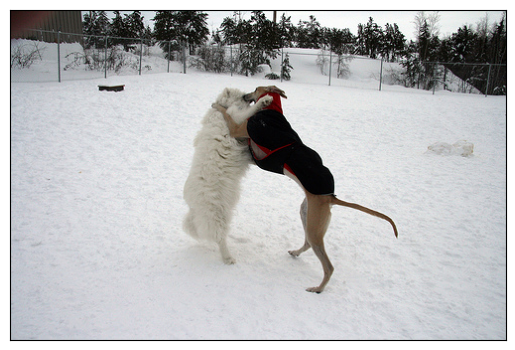

The dogs play in the snow on hind legs .
Two dogs jump on each other in the snow .
Two dogs play and appear to be hugging in the snow .
Two dogs playing in snow .
Two dogs wrestle in the snow in a fenced-in area .


In [31]:
image_id, captions = random.choice(list(load_dataset_dict("data/captions.txt").items()))
data_dir = "data/images"
full_image_path = os.path.join(data_dir, image_id)
image = Image.open(full_image_path)
plt.xticks([])
plt.yticks([])
plt.imshow(image)
plt.show()
for caption in captions:
    print(caption)


## EDA

In [32]:
df = pd.read_csv("data/captions.txt")
df_captions = df.caption

In [33]:
def count_words(df):
    vocabulary = []
    for txt in df.caption.values:
        vocabulary.extend(txt.split())
    counter = defaultdict(int)

    for word in vocabulary:
        counter[word.lower()] += 1
    sorted_items = sorted(counter.items(), key=lambda item: item[-1], reverse=True)


    df = pd.DataFrame(sorted_items, columns=['word', 'count'])

    return df

df_counter = count_words(df)

In [34]:
df_counter.head(10)

,word,count
0,a,62986
1,.,36577
2,in,18974
3,the,18418
4,on,10743
5,is,9345
6,and,8851
7,dog,8136
8,with,7765
9,man,7265


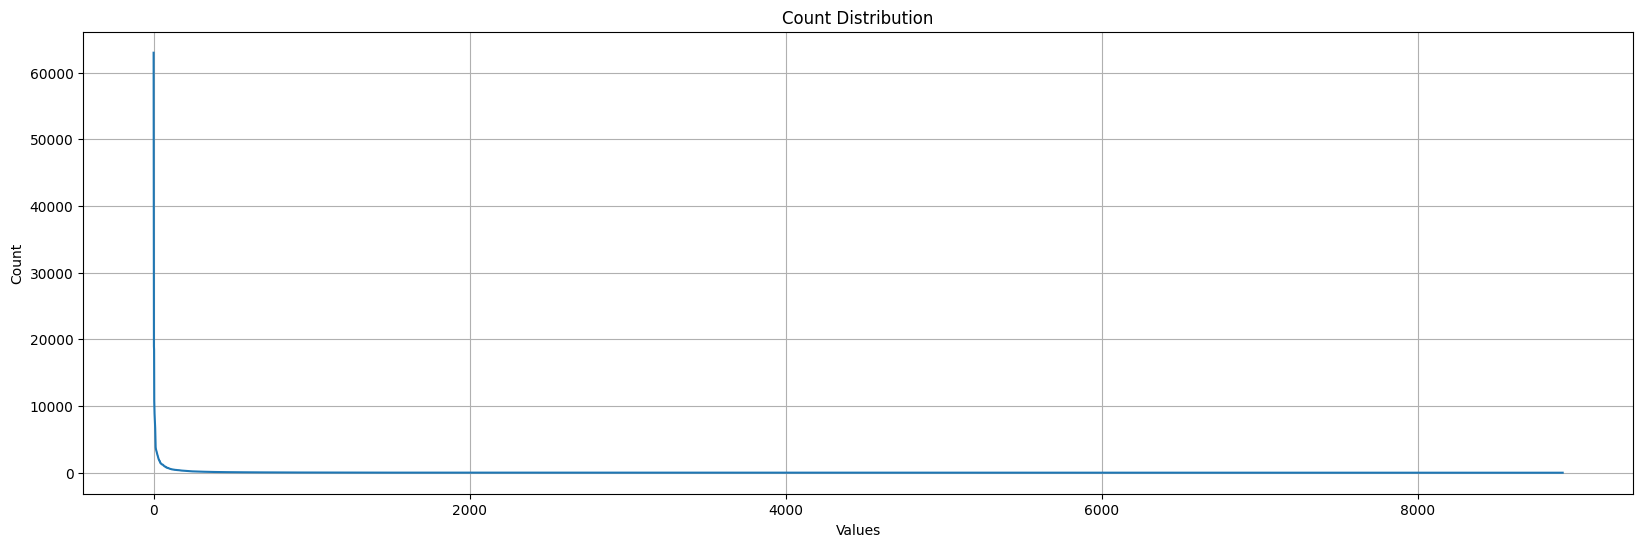

In [35]:
df_counter["count"].plot(grid=True, figsize=(20, 6))
plt.title("Count Distribution")
plt.xlabel("Values")
plt.ylabel("Count")
plt.show()

Text(0.5, 1.0, 'plot of count vs words')

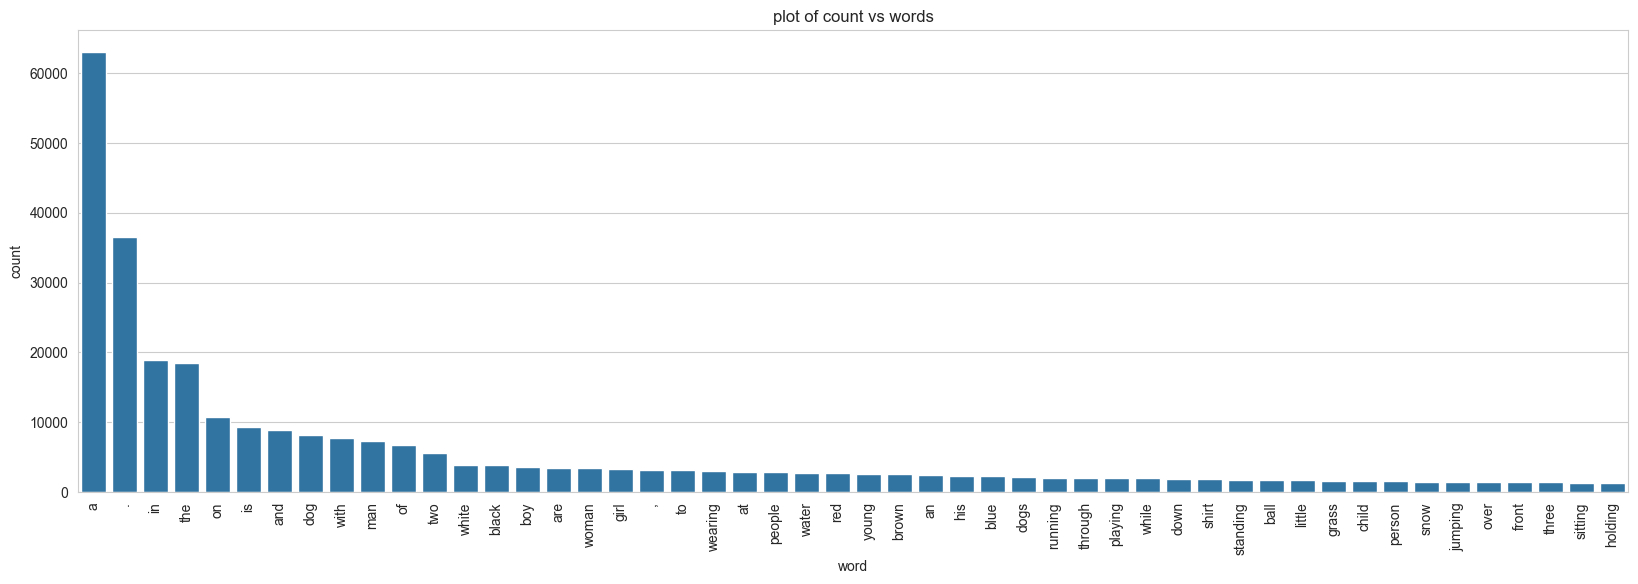

In [36]:
sns.set_style(style="whitegrid")
plt.figure(figsize=(20, 6))
sns.barplot(data=df_counter[:50], y='count', x="word")
plt.xticks(rotation="vertical")
plt.title("plot of count vs words")

In [37]:
"My name is Nathan".split()

['My', 'name', 'is', 'Nathan']

In [38]:
nlp = spacy.load("en_core_web_sm")
df['cal_len'] = df['caption'].apply(lambda x: len(nlp.tokenizer(x)))


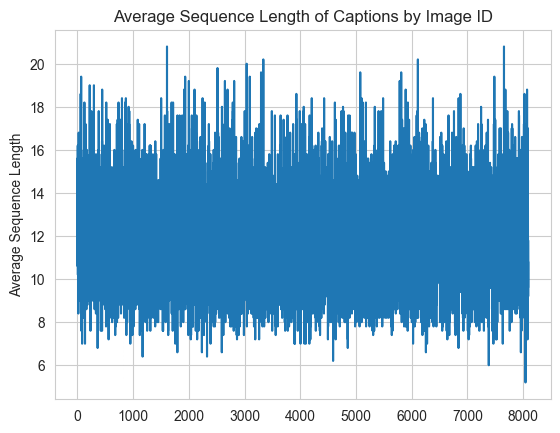

In [39]:
nlp = spacy.load("en_core_web_sm")
df['sequence_length'] = df['caption'].apply(lambda x: len(nlp.tokenizer(x)))

# Step 3: Group by 'image_id' and calculate the average sequence length
avg_sequence_length = df.groupby('image')['sequence_length'].mean().reset_index()
avg_sequence_length['sequence_length'].plot()
plt.ylabel('Average Sequence Length')
plt.title('Average Sequence Length of Captions by Image ID')
plt.show()

## Train, Val Split

In [2]:
def train_val_split(caption_data, train_size=0.8, shuffle=True):
    """Split the captioning dataset into train and validation sets.

    Args:
        caption_data (dict): Dictionary containing the mapped caption data
        train_size (float): Fraction of all the full dataset to use as training data
        shuffle (bool): Whether to shuffle the dataset before splitting

    Returns:
        Traning and validation datasets as two separated dicts
    """

    # 1. Get the list of all image names
    all_images = list(caption_data.keys())

    # 2. Shuffle if necessary
    if shuffle:
        np.random.shuffle(all_images)

    # 3. Split into training and validation sets
    train_size = int(len(caption_data) * train_size)

    training_data = {
        img_name: caption_data[img_name] for img_name in all_images[:train_size]
    }
    validation_data = {
        img_name: caption_data[img_name] for img_name in all_images[train_size:]
    }

    # 4. Return the splits
    return training_data, validation_data

In [3]:
df = pd.read_csv("data/captions.txt")
data_dict = {}
caption_dict = defaultdict(list)
for _, row in df.iterrows():
    caption_dict[row.image].append(row.caption)
train_data, val_data = train_val_split(caption_dict)

In [4]:
for i in train_data.values():
    for j in i:
        print(j)
    break

The rock climbers are on their equipment in front of a cave .
Two people hang from safety ropes over a giant cliff .
Two people hanging on a rope over a cliff .
Two people lower themselves into a cave with long ropes .
two people repel down into a hole .


In [5]:
hash_map = set()
for caption_list in train_data.values():
    for caption in caption_list:
        for word in caption.split():
            hash_map.add(word.lower())
len(hash_map)


8095

In [6]:
hash_map_val = set()
for caption_list in val_data.values():
    for caption in caption_list:
        for word in caption.split():
            hash_map_val.add(word.lower())
len(hash_map_val)

4092

## Vocabulary and tokenizer

In [45]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 47.1 MB/s eta 0:00:00 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [7]:

class Vocabulary():
    spacy_eng = spacy.load("en_core_web_sm")

    
    def __init__(self, freq_threshold):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {v:k for k,v in self.itos.items()}
        self.freq_threshold = freq_threshold

    
    def __len__(self):
        return len(self.itos)


    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in Vocabulary.spacy_eng.tokenizer(text)]
    
    def build_vocabulary(self, sentence_list):
        frequency = {}
        idx = 4

        for sentence in sentence_list:
            for token in self.tokenizer_eng(sentence):

                frequency[token] = 1 + frequency.get(token, 0)

                if frequency[token] == self.freq_threshold:
                    self.stoi[token] = idx
                    self.itos[idx] = token
                    idx += 1
    
    def tokenize(self, text):
        token_sent = self.tokenizer_eng(text)

        return [self.stoi[token] if token in self.stoi else self.stoi['<UNK>']
                for token in token_sent
            ]
    
    def vocabulary_size(self):
        return len(self.stoi)

In [8]:
vocabulary = Vocabulary(1)
vocabulary.build_vocabulary(pd.read_csv("data/captions.txt").caption.to_list())
vocabulary.vocabulary_size()

8508

In [9]:
vocabulary.tokenize("creates a human whose, name is not Tom James")

[5587, 4, 2634, 3150, 139, 7346, 9, 2183, 3, 3]

In [10]:
[vocabulary.itos[idx] for idx in [5587, 4, 2634, 3150, 139, 7346, 9, 2183, 3, 3]]

['creates', 'a', 'human', 'whose', ',', 'name', 'is', 'not', '<UNK>', '<UNK>']

In [11]:
vocabulary.stoi["<PAD>"]

0

In [12]:
class FlickrDataset(Dataset):
    max_len = 45
    def __init__(self, root_dir, data_dict, vocabulary: Vocabulary, transform=None, train=True):
        self.root_dir = root_dir
        self.data_dict = data_dict
        self.transform = transform

        # get the image and caption
        self.train = train
        self.caption = []
        self.item = self.setup_item()

        # Create our own vocabulary
        self.vocabulary = vocabulary
        self.sos_token = torch.tensor([self.vocabulary.stoi['<SOS>']], dtype=torch.int64)
        self.eos_token = torch.tensor([self.vocabulary.stoi['<EOS>']], dtype=torch.int64)
        self.pad_token = torch.tensor([self.vocabulary.stoi['<PAD>']], dtype=torch.int64)
    
    def __len__(self):
        return len(self.item)
    
    def setup_item(self):
        item = []
        if self.train:
            for image_id, image_captions in self.data_dict.items():
                for caption in image_captions:
                    self.caption.append(caption)
                    item.append((image_id, caption))
        else:
            for image_id, image_captions in self.data_dict.items():
                self.caption.extend(image_captions)
                item.append((image_id, image_captions))
        return item


    def __getitem__(self, index):
        # get image
        image_path = os.path.join(self.root_dir, self.item[index][0])
        img = Image.open(image_path).convert('RGB')

        if self.transform is not None:
            img = self.transform(img)
        
        # get caption
        caption = self.item[index][1]
        
        if self.train:
            cap_len = len(self.vocabulary.tokenize(caption))
            num_pad = FlickrDataset.max_len - cap_len - 2
            if num_pad < 0:
                raise ValueError("Caption too long")
            num_caption = torch.cat([
                        self.sos_token ,
                        torch.tensor(self.vocabulary.tokenize(caption), dtype=torch.int64),
                        self.eos_token,
                        torch.tensor([self.pad_token] * num_pad, dtype=torch.int64)], dim=0)
            return img, num_caption
        else:
            captions = torch.zeros(5, 45).to(torch.long)
            for idx, cap in enumerate(caption):
                cap_len = len(self.vocabulary.tokenize(cap))
                num_pad = FlickrDataset.max_len - cap_len - 2
                if num_pad < 0:
                    raise ValueError("Caption too long")
                num_caption =    torch.cat([
                        self.sos_token ,
                        torch.tensor(self.vocabulary.tokenize(cap), dtype=torch.int64),
                        self.eos_token,
                        torch.tensor([self.pad_token] * num_pad, dtype=torch.int64)], dim=0)

                captions[idx] = num_caption
            return img, torch.LongTensor(captions)


In [13]:
def get_loader(
        root_dir,
        data_dict,
        vocabulary,
        transform,
        train=True,
        batch_size=32,
        shuffle=True,
):
    dataset = FlickrDataset(root_dir=root_dir, data_dict=data_dict, vocabulary=vocabulary,
                        transform=transform, train=train)
        
    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
    )
    return loader, dataset

### Testing Dataset(and DataLoader) for train and test with vocabulatry

In [14]:
vocabulary = Vocabulary(1)
vocabulary.build_vocabulary(pd.read_csv("data/captions.txt").caption.to_list())
vocabulary.vocabulary_size()

8508

In [15]:
folder = "data/images/"
df = pd.read_csv("data/captions.txt")
data_dict = {}
caption_dict = defaultdict(list)
for _, row in df.iterrows():
    caption_dict[row.image].append(row.caption)
train_data, val_data = train_val_split(caption_dict)

In [16]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                         std=[0.26862954, 0.26130258, 0.27577711])
])

In [17]:
train_dataset = FlickrDataset(root_dir=folder, data_dict=train_data,vocabulary=vocabulary,
                        transform=transform, train=True)

In [18]:
random_index = random.randint(0, len(train_dataset) - 1)

# Get the random element
random_image, random_label = train_dataset[random_index]

print("Random Shape:", random_image.shape)
print("Random Caption:", random_label.shape)

Random Shape: torch.Size([3, 224, 224])
Random Caption: torch.Size([45])


In [19]:
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
for image, caption in train_loader:
    print(caption.shape)
    print(image.shape)
    index = random.randint(0, 31)
    first_image = image[index]
    print(first_image.shape)
    first_caption = caption[index]
    print(first_caption.shape)
    break

torch.Size([32, 45])
torch.Size([32, 3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([45])


In [20]:
val_dataset = FlickrDataset(root_dir=folder, data_dict=val_data,vocabulary=vocabulary,
                        transform=transform, train=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5148925..2.145897].


Random Shape: torch.Size([3, 224, 224])
Random Caption: torch.Size([5, 45])


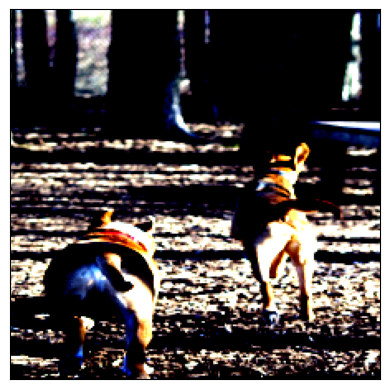

['<SOS>', 'two', 'dogs', 'are', 'running', 'up', 'a', 'woodland', 'path', '.', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
['<SOS>', 'two', 'dogs', 'run', 'across', 'the', 'woods', '.', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
['<SOS>', 'two', 'dogs', 'running', 'toward', 'trees', '.', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>

In [21]:
random_index = random.randint(0, len(val_dataset) - 1)

# Get the random element
random_image, random_label = val_dataset[random_index]

print("Random Shape:", random_image.shape)
print("Random Caption:", random_label.shape)
plt.xticks([])
plt.yticks([])
plt.imshow(random_image.permute(1, 2,0))
plt.show()
print([vocabulary.itos[token] for token in random_label[0].tolist()])
print([vocabulary.itos[token] for token in random_label[1].tolist()])
print([vocabulary.itos[token] for token in random_label[2].tolist()])
print([vocabulary.itos[token] for token in random_label[3].tolist()])
print([vocabulary.itos[token] for token in random_label[4].tolist()])

In [22]:
folder

'data/images/'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7520971..2.145897].


torch.Size([32, 5, 45])
torch.Size([32, 3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([5, 45])


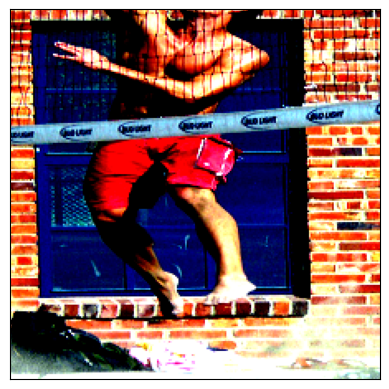

['<SOS>', 'a', 'man', 'in', 'red', 'shorts', 'jumping', 'in', 'back', 'of', 'a', 'volleyball', 'net', '.', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
['<SOS>', 'a', 'man', 'in', 'red', 'shorts', 'jumps', 'behind', 'a', 'volleyball', 'net', '.', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
['<SOS>', 'a', 'man', 'in', 'red', 'swim', 'trunks', 'playing', 'volleyball', '.', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PA

In [23]:
val_loader, _ = get_loader(root_dir=folder, data_dict=val_data, vocabulary=vocabulary, transform=transform, train=False)

for image, caption in val_loader:
    print(caption.shape)
    print(image.shape)
    index = random.randint(0, 31)
    random_image = image[index]
    print(random_image.shape)
    random_label = caption[index]
    print(random_label.shape)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(random_image.permute(1, 2,0))
    plt.show()
    print([vocabulary.itos[token] for token in random_label[0].tolist()])
    print([vocabulary.itos[token] for token in random_label[1].tolist()])
    print([vocabulary.itos[token] for token in random_label[2].tolist()])
    print([vocabulary.itos[token] for token in random_label[3].tolist()])
    print([vocabulary.itos[token] for token in random_label[4].tolist()])
    break

## Model

In [24]:
from torchvision.models import vgg19, VGG19_Weights
import torch.nn as nn

### ecoder test

In [64]:
model = vgg19(weights=VGG19_Weights.DEFAULT)

In [65]:
model = nn.Sequential(*list(model.features.children())[:-1])

In [66]:
img, caption = train_dataset[0]
img.shape

torch.Size([3, 224, 224])

In [67]:
output = model(img)
output.shape

torch.Size([512, 14, 14])

### Encoder

In [25]:
class Encoder(nn.Module):

    def __init__(self, train_CNN=False):
        super(Encoder, self).__init__() # staying consistent with the paper by using vgg
        self.train_CNN = train_CNN
        self.model = vgg19()
        self.model = nn.Sequential(*list(self.model.features.children())[:-1])
        self.dim = 512
        self.freeze()
        
    
    def freeze(self):
        for param in self.model.parameters():
            param.requires_grad = self.train_CNN

    def forward(self, images):
        features = self.model(images)
        features = features.permute(0, 2, 3, 1)
        features = features.view(features.shape[0], -1, features.shape[-1])
        return features # output should be of shape (batch_size, 196, 512)
    

In [69]:
import torchvision
from torchvision.models import ResNet101_Weights
class Encoder(nn.Module):
    """
    Encoder.
    """

    def __init__(self, encoded_image_size=14):
        super(Encoder, self).__init__()
        self.enc_image_size = encoded_image_size

        resnet = torchvision.models.resnet101()  # pretrained ImageNet ResNet-101

        # Remove linear and pool layers (since we're not doing classification)
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)

        # Resize image to fixed size to allow input images of variable size
        self.adaptive_pool = nn.AdaptiveAvgPool2d((encoded_image_size, encoded_image_size))
        self.dim = 2048
        #self.fine_tune()

    def forward(self, images):
        """
        Forward propagation.

        :param images: images, a tensor of dimensions (batch_size, 3, image_size, image_size)
        :return: encoded images
        """
        out = self.resnet(images)  # (batch_size, 2048, image_size/32, image_size/32)
        out = self.adaptive_pool(out)  # (batch_size, 2048, encoded_image_size, encoded_image_size)
        out = out.permute(0, 2, 3, 1)  # (batch_size, encoded_image_size, encoded_image_size, 2048)
        out = out.view(out.shape[0],-1,out.shape[-1])
        return out

### Test

In [70]:
image_path = 'data/images/10815824_2997e03d76.jpg'

# Load the image
image = Image.open(image_path)

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                         std=[0.26862954, 0.26130258, 0.27577711])
])

# Apply the transformation
ENCODER_DIM = 2048
DECODER_DIM = 256
EMBED_DIM = 64
ATTENTION_DIM = 128
image_tensor = transform(image)

# Add a batch dimension if needed
image_tensor = image_tensor.unsqueeze(0)
enocder = Encoder()
output = enocder(image_tensor)
print("encoded image shape: ", output.shape)


# caption
caption = "<SOS> A blonde horse and a blonde girl in a black sweatshirt are staring at a fire in a barrel .<EOS>"
caption = vocabulary.tokenize(caption)
caption = torch.tensor(caption).unsqueeze(0)
print("tokenize caption shape:", caption.shape)

# embedding the caption
embedding = nn.Embedding(vocabulary.vocabulary_size(), EMBED_DIM)
caption = embedding(caption)
print("embedded caption shape:", caption.shape)

# initlize your values for h and c
init_h = nn.Linear(ENCODER_DIM, DECODER_DIM)
init_c = nn.Linear(ENCODER_DIM, DECODER_DIM)

average_out = output.mean(dim=1)
h = init_h(average_out)
c = init_c(average_out)
print("shape of average encoder output:", average_out.shape)
print("shape of initial h:", h.shape)
print("shape of inital c:", c.shape)

## initilizeing predictions and alpha (will be returned)
prediction = torch.zeros(1, caption.shape[1], vocabulary.vocabulary_size())


## Attention
encoder_attention = nn.Linear(ENCODER_DIM, ATTENTION_DIM)
decorder_attention = nn.Linear(DECODER_DIM, ATTENTION_DIM)
attend = nn.Linear(ATTENTION_DIM, 1)

# Decoder
lstm = nn.LSTMCell(ENCODER_DIM+EMBED_DIM, DECODER_DIM)
fc = nn.Linear(DECODER_DIM, vocabulary.vocabulary_size())



for i in range(caption.shape[1]):
        
        ## attention forward method
        print("--------- START ATTENTION CALCULATION -----------")
        tmp_img = encoder_attention(output)
        tmp_h = decorder_attention(h).unsqueeze(1)
        print("encoder output attention shape:", {tmp_img.shape})
        print("hidden output attention shape:", {tmp_h.shape})
        add = nn.Tanh()(tmp_img + tmp_h)
        print("Sum of enocder and hidden output shape: ", {add.shape})
        att = attend(add).squeeze(2)
        print("non scaled attention score shape:", {att.shape})
        alpha = nn.Softmax(dim=1)(att).unsqueeze(1)
        print("alpha shape:", alpha.shape)
        weighted_context = torch.bmm(alpha, output).squeeze(1)
        print("full weighted context shape:", {weighted_context.shape})
        
        print("--------- DONE CALCULATING ATTENTION SCORE -----------")
        print(caption[:,i,:].shape)
        lstm_input = torch.cat([caption[:,i,:], weighted_context], dim=1)
        print("LSTM input shape:",lstm_input.shape)
        print("SUM of encoder and embed DIM", ENCODER_DIM+EMBED_DIM)
        h, c = lstm(lstm_input, (h, c))
        word_prop = fc(h)
        print("word_proabability shape:", word_prop.shape)
        prediction[:,i,:] = word_prop
        break

print("--------- DONE DECORDER -----------")
print("final predictions shape:", {prediction.shape}) 
print("Argmax", prediction.max(dim=-1))


encoded image shape:  torch.Size([1, 196, 2048])
tokenize caption shape: torch.Size([1, 24])
embedded caption shape: torch.Size([1, 24, 64])
shape of average encoder output: torch.Size([1, 2048])
shape of initial h: torch.Size([1, 256])
shape of inital c: torch.Size([1, 256])
--------- START ATTENTION CALCULATION -----------
encoder output attention shape: {torch.Size([1, 196, 128])}
hidden output attention shape: {torch.Size([1, 1, 128])}
Sum of enocder and hidden output shape:  {torch.Size([1, 196, 128])}
non scaled attention score shape: {torch.Size([1, 196])}
alpha shape: torch.Size([1, 1, 196])
full weighted context shape: {torch.Size([1, 2048])}
--------- DONE CALCULATING ATTENTION SCORE -----------
torch.Size([1, 64])
LSTM input shape: torch.Size([1, 2112])
SUM of encoder and embed DIM 2112
word_proabability shape: torch.Size([1, 8508])
--------- DONE DECORDER -----------
final predictions shape: {torch.Size([1, 24, 8508])}
Argmax torch.return_types.max(
values=tensor([[0.5699, 

In [71]:
image_path = 'data/images/10815824_2997e03d76.jpg'

# Load the image
image = Image.open(image_path)

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                         std=[0.26862954, 0.26130258, 0.27577711])
])

# Apply the transformation
ENCODER_DIM = 512
DECODER_DIM = 256
EMBED_DIM = 64
ATTENTION_DIM = 128
image_tensor = transform(image)

# Add a batch dimension if needed
image_tensor = image_tensor.unsqueeze(0)
enocder = Encoder()
output = enocder(image_tensor)
print("encoded image shape: ", output.shape)


# caption
caption = "<SOS> A blonde horse and a blonde girl in a black sweatshirt are staring at a fire in a barrel .<EOS>"
caption = vocabulary.tokenize(caption)
caption = torch.tensor(caption).unsqueeze(0)
print("tokenize caption shape:", caption.shape)

# embedding the caption
embedding = nn.Embedding(vocabulary.vocabulary_size(), EMBED_DIM)
caption = embedding(caption)
print("embedded caption shape:", caption.shape)

# initlize your values for h and c
init_h = nn.Linear(ENCODER_DIM, DECODER_DIM)
init_c = nn.Linear(ENCODER_DIM, DECODER_DIM)

average_out = output.mean(dim=1)
h = init_h(average_out)
c = init_c(average_out)
print("shape of average encoder output:", average_out.shape)
print("shape of initial h:", h.shape)
print("shape of inital c:", c.shape)

## initilizeing predictions and alpha (will be returned)
prediction = torch.zeros(1, caption.shape[1], vocabulary.vocabulary_size())


## Attention
encoder_attention = nn.Linear(ENCODER_DIM, ATTENTION_DIM)
decorder_attention = nn.Linear(DECODER_DIM, ATTENTION_DIM)
attend = nn.Linear(ATTENTION_DIM, 1)

# Decoder
lstm = nn.LSTMCell(ENCODER_DIM+EMBED_DIM, DECODER_DIM)
fc = nn.Linear(DECODER_DIM, vocabulary.vocabulary_size())



for i in range(caption.shape[1]):
        
        ## attention forward method
        ## attention forward method
        tmp_img = encoder_attention(output)
        tmp_h = decorder_attention(h).unsqueeze(1)
        print("encoder output attention shape:", {tmp_img.shape})
        print("hidden output attention shape:", {tmp_h.shape})
        add = nn.Tanh()(tmp_img + tmp_h)
        print("Sum of enocder and hidden output shape: ", {add.shape})
        att = attend(add).squeeze(2)
        print("non scaled attention score shape:", {att.shape})
        alpha = nn.Softmax(dim=1)(att)
        print("alpha shape:", alpha.shape)
        weighted_context = (output * alpha.unsqueeze(2))
        print("unsqueze weight context shape:", weighted_context.shape)
        weighted_context = weighted_context.sum(dim=1)
        print("full weighted context shape:", {weighted_context.shape})
        
        print("--------- DONE CALCULATING ATTENTION SCORE -----------")
        print(caption[:,i,:].shape)
        lstm_input = torch.cat([caption[:,i,:], weighted_context], dim=1)
        print(lstm_input.shape)
        h, c = lstm(lstm_input, (h, c))
        word_prop = fc(h)
        print("word_proabability shape:", word_prop.shape)
        prediction[:,i,:] = word_prop
        break

print("--------- DONE DECORDER -----------")
print("final predictions shape:", {prediction.shape}) 
print("Argmax", prediction.argmax(dim=-1))



encoded image shape:  torch.Size([1, 196, 2048])
tokenize caption shape: torch.Size([1, 24])
embedded caption shape: torch.Size([1, 24, 64])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x2048 and 512x256)

### Attention

#### Test

In [ ]:
device = "cpu"
class ImageEncoder(nn.Module):
    def __init__(self, enc_image_size=14):
        super(ImageEncoder, self).__init__()
        self.enc_image_size = enc_image_size

        # pretrained ImageNet ResNet-101
        resnet = torchvision.models.resnet101(pretrained=True)

        # remove linear and pool layers
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)

        # resize image to fixed size using adaptive pool to allow input images of variable size
        self.adaptive_pool = nn.AdaptiveAvgPool2d((enc_image_size, enc_image_size))

        self.fine_tune()

    def fine_tune(self, fine_tune=True):
        """
        Allow or prevent computation of the gradients for convolutional blocks 2 through 4 of the image encoder.
        :param fine_tune: boolean
        """
        for param in self.resnet.parameters():
            param.requires_grad = False
        # if fine-tuning, fine-tune convolutional blocks 2 through 4
        for child in list(self.resnet.children())[5:]:
            for param in child.parameters():
                param.requires_grad = fine_tune
    
    def forward(self, images):
        """
        Forward propagation.
        :param images: images, a tensor of dim (batch_size, 3, image_size, image_size)
        :return enc_images: encoded repr of images, a tensor of dim (batch_size, enc_image_size, enc_image_size, 2048)
        """
        out = self.resnet(images)       # (batch_size, 2048, image_size/32, image_size/32)
        out = self.adaptive_pool(out)   # (batch_size, 2048, enc_image_size, enc_image_size)
        out = out.permute(0, 2, 3, 1)   # (batch_size, enc_image_size, enc_image_size, 2048)
        return out
    
class BahdanauAttention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        """
        :param encoder_dim: feature size of encoded images
        :param decoder_dim: size of decoder's RNN
        :param attention_dim: size of the attention network
        """
        super(BahdanauAttention, self).__init__()
        self.encoder_attn = nn.Linear(encoder_dim, attention_dim)   # linear layer to transform encoder's output
        self.decoder_attn = nn.Linear(decoder_dim, attention_dim)   # linear layer to transform decoder's output
        self.full_attn = nn.Linear(attention_dim, 1)
    
    def forward(self, encoder_out, decoder_hidden):
        """
        Forward propagation (uses Multiplicative attention).
        :param encoder_out: encoded images, a tensor of dim (batch_size, num_pixels, encoder_dim)
        :param decoder_hidden: previous decoder output, a tensor of dim (batch_size, decoder_dim)
        """
        attn1 = self.encoder_attn(encoder_out)          # (batch_size, num_pixels, attention_dim)
        attn2 = self.decoder_attn(decoder_hidden)       # (batch_size, attention_dim)
        attn = self.full_attn(F.relu(attn1 + attn2.unsqueeze(1)))    # (batch_size, num_pixels, 1)

        # apply softmax to calculate weights for weighted encoding based on attention
        alpha = F.softmax(attn, dim=1)                  # (batch_size, num_pixels, 1)
        attn_weighted_encoding = (encoder_out * alpha).sum(dim=1)  # (batch_size, encoder_dim)
        alpha = alpha.squeeze(2)  # (batch_size, num_pixels)
        return attn_weighted_encoding, alpha
    
attention = BahdanauAttention(encoder_dim=256, decoder_dim=512, attention_dim=128)

encoder_outputs = torch.rand(32, 10, 256)  # Batch size 32, sequence length 10, encoder dim 256
decoder_hidden = torch.rand(32, 512)       # Batch size 32, decoder dim 512

context_vector, attn_weights = attention(encoder_outputs, decoder_hidden)
print(context_vector.shape)  # (32, 256)
print(attn_weights.shape)    # (32, 10)
print(context_vector.argmax(dim=-1))
print(attn_weights.max(dim=-1))

torch.Size([32, 256])
torch.Size([32, 10])
tensor([ 10,  47,  23,  28, 147, 220, 120, 108, 178,   2, 140,  50, 178, 178,
         58, 187, 245, 123,  36, 166, 194, 216, 136,  88,  56, 134,   3,  15,
        200,  41, 228, 117])
torch.return_types.max(
values=tensor([0.1051, 0.1163, 0.1101, 0.1133, 0.1043, 0.1125, 0.1125, 0.1099, 0.1076,
        0.1077, 0.1168, 0.1071, 0.1118, 0.1078, 0.1120, 0.1126, 0.1087, 0.1157,
        0.1097, 0.1082, 0.1076, 0.1055, 0.1167, 0.1185, 0.1127, 0.1215, 0.1079,
        0.1118, 0.1072, 0.1259, 0.1073, 0.1132], grad_fn=<MaxBackward0>),
indices=tensor([1, 1, 1, 9, 4, 4, 9, 5, 3, 3, 0, 9, 4, 9, 0, 4, 7, 4, 8, 2, 6, 9, 3, 6,
        0, 1, 1, 8, 9, 9, 5, 2]))


In [ ]:
import torchvision
from torchvision.models import ResNet101_Weights
class Encoder(nn.Module):
    """
    Encoder.
    """

    def __init__(self, encoded_image_size=14):
        super(Encoder, self).__init__()
        self.enc_image_size = encoded_image_size

        resnet = torchvision.models.resnet101()  # pretrained ImageNet ResNet-101

        # Remove linear and pool layers (since we're not doing classification)
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)

        # Resize image to fixed size to allow input images of variable size
        self.adaptive_pool = nn.AdaptiveAvgPool2d((encoded_image_size, encoded_image_size))
        self.dim = 2048
        #self.fine_tune()

    def forward(self, images):
        """
        Forward propagation.

        :param images: images, a tensor of dimensions (batch_size, 3, image_size, image_size)
        :return: encoded images
        """
        out = self.resnet(images)  # (batch_size, 2048, image_size/32, image_size/32)
        out = self.adaptive_pool(out)  # (batch_size, 2048, encoded_image_size, encoded_image_size)
        out = out.permute(0, 2, 3, 1)  # (batch_size, encoded_image_size, encoded_image_size, 2048)
        out = out.view(out.shape[0],-1,out.shape[-1])
        return out

#### Implementation

In [26]:
class Attention(nn.Module):
    """
    Attention Network.
    """

    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        """
        :param encoder_dim: feature size of encoded images
        :param decoder_dim: size of decoder's RNN
        :param attention_dim: size of the attention network
        """
        super(Attention, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim, bias=False)  # linear layer to transform encoded image
        self.decoder_att = nn.Linear(decoder_dim, attention_dim, bias=False)  # linear layer to transform decoder's output
        self.full_att = nn.Linear(attention_dim, 1, bias=False)  # linear layer to calculate values to be softmax-ed
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)  # softmax layer to calculate weights
        nn.init.xavier_normal_(self.encoder_att.weight)
        nn.init.xavier_normal_(self.decoder_att.weight)
        nn.init.xavier_normal_(self.full_att.weight)

    def forward(self, encoder_out, decoder_hidden):
        """
        Forward propagation.
        num pixel is just 196 in out case
        :param encoder_out: encoded images, a tensor of dimension (batch_size, num_pixels, encoder_dim)
        :param decoder_hidden: previous decoder output, a tensor of dimension (batch_size, decoder_dim)
        :return: attention weighted encoding, weights ()
        """
        att1 = self.encoder_att(encoder_out)  # (batch_size, num_pixels, attention_dim)
        att2 = self.decoder_att(decoder_hidden)  # (batch_size, attention_dim)
        att = self.full_att(self.relu(att1 + att2.unsqueeze(1))).squeeze(-1)  # (batch_size, num_pixels, 1) -> (batch_size, num_pixels)
        alpha = self.softmax(att).unsqueeze(1)  # (batch_size, 1, num_pixels)
        attention_weighted_encoding = torch.bmm(alpha, encoder_out).squeeze(1)  # (batch_size, encoder_dim)
        return attention_weighted_encoding, alpha.squeeze(1)
        
attention = Attention(encoder_dim=512, decoder_dim=512, attention_dim=128)

for images, _ in train_loader:
    break
encoder = Encoder()
encoder_outputs = encoder(images)
alphas = torch.zeros(32, 45, 196)

for i in range(45):
    h = torch.randn(32, 512)
    context_vector, attn_weights = attention(encoder_outputs, h)
    alphas[:,i,:] = attn_weights

print(context_vector.argmax(dim=-1))  # (32, 256)
print(attn_weights.argmax(dim=-1))
print(alphas.shape)    # (32, 10)
print(alphas[3].max(dim=-1))
print("-"*100)
print(alphas[0].max(dim=-1))
print("-"*100)
print(alphas[19].max(dim=-1))


tensor([334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334,
        334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334,
        334, 334, 334, 334])
tensor([ 66,  30,  32,  39, 179,  33,  62,  79, 112, 121,  77,  30,  38,  81,
        177,  75,  65,  39,  98,  47,  37, 121,  33,  40, 122,  62, 104,  62,
        128,  91,  72,  77])
torch.Size([32, 45, 196])
torch.return_types.max(
values=tensor([0.0059, 0.0059, 0.0057, 0.0058, 0.0058, 0.0063, 0.0068, 0.0062, 0.0064,
        0.0059, 0.0058, 0.0062, 0.0061, 0.0065, 0.0064, 0.0064, 0.0063, 0.0064,
        0.0059, 0.0063, 0.0058, 0.0060, 0.0056, 0.0064, 0.0067, 0.0062, 0.0059,
        0.0063, 0.0058, 0.0061, 0.0062, 0.0063, 0.0064, 0.0058, 0.0060, 0.0058,
        0.0059, 0.0060, 0.0061, 0.0063, 0.0062, 0.0058, 0.0062, 0.0063, 0.0068],
       grad_fn=<MaxBackward0>),
indices=tensor([ 39,  80, 188,  34,  91,  66,  39, 173,  39, 160,  35,  39,  39,  39,
         39,  66,  39,  39,  80,  39,  66,  80,  46,  

In [78]:
class BahdanauAttention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super(BahdanauAttention, self).__init__()
        self.W_enc = nn.Linear(encoder_dim, attention_dim, bias=False)
        self.W_dec = nn.Linear(decoder_dim, attention_dim, bias=False)
        self.v = nn.Linear(attention_dim, 1, bias=False)
        self.softmax = nn.Softmax(dim=1)
        nn.init.xavier_normal_(self.W_enc.weight)
        nn.init.xavier_normal_(self.W_dec.weight)
        nn.init.xavier_normal_(self.v.weight)

    def forward(self, encoder_features, decoder_hidden):
        decoder_hidden = decoder_hidden.unsqueeze(1)  # Shape: (batch, 1, attention_dim)
        scores = self.v(torch.tanh(self.W_enc(encoder_features) + self.W_dec(decoder_hidden)))
        attention_weights = self.softmax(scores.squeeze(2))  # Shape: (batch, 196)
        context_vector = torch.bmm(attention_weights.unsqueeze(1), encoder_features).squeeze(1)  # (batch, encoder_dim)
        return context_vector, attention_weights

attention = BahdanauAttention(encoder_dim=512, decoder_dim=512, attention_dim=128)

for images, _ in train_loader:
    break
encoder = Encoder()
encoder_outputs = encoder(images)
alphas = torch.zeros(32, 45, 196)

for i in range(45):
    h = torch.rand(32, 512)
    context_vector, attn_weights = attention(encoder_outputs, h)
    alphas[:,i,:] = attn_weights

print(context_vector.argmax(dim=-1))  # (32, 256)
print(attn_weights.argmax(dim=-1))
print(alphas.shape)    # (32, 10)
print(alphas[3].max(dim=-1))
print("-"*100)
print(alphas[0].max(dim=-1))
print("-"*100)
print(alphas[19].max(dim=-1))

tensor([229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229,
        199, 199, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229,
        229, 199, 229, 229])
tensor([ 66, 142,  60, 103,  76, 122, 116, 116,  65, 106, 114,  38,  74,  48,
         91, 135,  89,  29, 180, 142,  64,  29, 120,  30, 116,  32,  30, 106,
         46,  31,  88,  30])
torch.Size([32, 45, 196])
torch.return_types.max(
values=tensor([0.0063, 0.0068, 0.0064, 0.0061, 0.0060, 0.0062, 0.0063, 0.0062, 0.0064,
        0.0064, 0.0062, 0.0060, 0.0064, 0.0064, 0.0064, 0.0061, 0.0064, 0.0063,
        0.0064, 0.0064, 0.0061, 0.0061, 0.0061, 0.0067, 0.0060, 0.0063, 0.0062,
        0.0063, 0.0063, 0.0065, 0.0062, 0.0062, 0.0060, 0.0060, 0.0062, 0.0062,
        0.0062, 0.0061, 0.0062, 0.0062, 0.0064, 0.0059, 0.0063, 0.0063, 0.0065],
       grad_fn=<MaxBackward0>),
indices=tensor([103, 103, 103, 121, 103, 103, 121, 103, 103, 103, 103, 107, 121, 121,
        103, 103, 121, 121, 103, 103, 103, 121, 107, 1

In [27]:
class Decoder(nn.Module):
    
    def __init__(self, embed_dim, attention_dim, encoder_dim, decoder_dim, vocab_size, dropout):

        super(Decoder, self).__init__()
        self.attention = Attention(encoder_dim=encoder_dim, decoder_dim=decoder_dim, attention_dim=attention_dim)

        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.dropout = nn.Dropout(dropout)

        self.f_beta = nn.Linear(decoder_dim, encoder_dim)
        self.sigmoid = nn.Sigmoid()

        self.init_h = nn.Linear(encoder_dim, decoder_dim)
        self.init_c = nn.Linear(encoder_dim, decoder_dim)
        self.lstm = nn.LSTMCell(embed_dim + encoder_dim, decoder_dim)

        self.output = nn.Linear(decoder_dim, vocab_size)
        self.vocab_size = vocab_size

    
    def init_hidden_state(self, encoder_out: torch.Tensor):
        average_out = encoder_out.mean(dim=1) # output of shape (batch_size,  encoder_dim)
        h = self.init_h(average_out) # -> (batch_size,  decoder_dim)
        c = self.init_c(average_out) # -> (batch_size,  decoder_dim)
        return h, c
    

    def forward(self, encoder_out, caption):
        '''
        encoder_out will be of shape (batch_size, num_pixels, encoder_dim) eg (32, 196, 512)
        caption will be of shape (batch_size, 44) for training (only dealing with one caption) eg (32, 44)
        '''
        embeddings = self.embedding(caption) # -> (batch_size, max_seq_length, embedding_dim)
        cap_len = caption.size(-1)

        h, c = self.init_hidden_state(encoder_out) # both are of shape (batch_size, decoder_dim)
        device = h.device

        predictions = torch.zeros(caption.shape[0], caption.shape[1], self.vocab_size).to(device)
        alphas = torch.zeros(caption.shape[0], caption.shape[1], encoder_out.shape[1]).to(device)

        for i in range(cap_len):
            weighted_context, alpha = self.attention(encoder_out, h)
            #gate = self.sigmoid(self.f_beta(h))
            #weighted_context = gate * weighted_context
            
            # (batch_size, embedding_dim), (batch_size, encoder_dim) -> (batch_size, embedding_dim + encoder_dim)
            lstm_input = torch.cat([weighted_context, embeddings[:,i,:]], dim=1)
            h, c = self.lstm(lstm_input, (h, c)) # both are of shape (batch_size, decoder_dim)
            word_prop = self.output(self.dropout(h))  # shape (batch_size, vocab_size)
            
            predictions[:,i,:] = word_prop
            alphas[:,i,:] = alpha
                
        return predictions, alphas


### test decoder

In [81]:
device = 'mps'
for images, caption in train_loader:
    images, caption = images.to(device), caption.to(device)
    break
encoder = Encoder().to(device)


output = encoder(images)
#print(output.argmax(dim=-1))
decoder = Decoder(64, 32, 512, 128, vocabulary.vocabulary_size(), 0.1).to(device)
preds, alphas = decoder(output, caption)
#print("fist prediction: ", preds[0])
#print("Arg max: ", preds[0].argmax(dim=-1))
print("prediction max values for a batch", preds[0,:,:].max(dim=-1))
print("-"*100)
print("alpha max values for a batch", alphas[0,:,:].max(dim=-1))

prediction max values for a batch torch.return_types.max(
values=tensor([0.6068, 0.8721, 0.9136, 1.0633, 1.1821, 1.0592, 1.2276, 1.4471, 1.1279,
        1.2052, 1.2277, 1.1485, 1.1830, 1.1686, 1.1382, 1.1487, 1.3128, 1.2256,
        1.2169, 1.1765, 1.2180, 1.1864, 1.3485, 1.2100, 1.1758, 1.3107, 1.1959,
        1.1861, 1.3187, 1.0903, 1.1152, 1.1763, 1.2367, 1.1817, 1.2664, 1.2036,
        1.1382, 1.2825, 1.2033, 1.2862, 1.0791, 1.4220, 1.1281, 1.2163, 1.2551],
       device='mps:0', grad_fn=<MaxBackward0>),
indices=tensor([1687, 1687, 1337, 6633, 1687, 1337, 7899, 7899, 7899, 6633, 1687, 7899,
        7899, 7899, 7899, 7899, 7899, 1687, 1687, 1687, 6265, 7899, 7899, 2415,
        7899, 7899, 7899, 1687, 7899, 1687, 1687, 7899, 1687, 7899, 7899, 1687,
        1687, 7899, 1687, 7899, 1687, 7899, 6633, 7899, 7899], device='mps:0'))
----------------------------------------------------------------------------------------------------
alpha max values for a batch torch.return_types.max(
valu

### Caption

In [28]:
class Caption(nn.Module):
    def __init__(self, embed_dim, attention_dim, encoder_dim, decoder_dim, vocab_size, dropout):
        super(Caption, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder(embed_dim=embed_dim, attention_dim=attention_dim,
                               encoder_dim=encoder_dim, decoder_dim=decoder_dim, vocab_size=vocab_size, dropout=dropout)
        #self.encoder.fine_tine()
    
    def forward(self, img, captions):
        features = self.encoder(img)
        predictions, alphas = self.decoder(features, captions)
        return predictions, alphas

    def caption_img(self, img, vocab, max_length=100):
        result_caption = []

        with torch.no_grad():
            feature = self.encoder(img) # (batch_size, num_pixels, decoder_dim) 
            h, c = self.decoder.init_hidden_state(feature)

            ## first input to the model
            start = torch.zeros(size=(1,), dtype=torch.int)
            start[0] = vocabulary.stoi['<SOS>']
            start = start.unsqueeze(0) # shape (1, 1)
            start = start.to(h.device)
            embeddings = self.decoder.embedding(start).squeeze(0) # (1, embed_dim)
            print("Embedding Shape:", embeddings.shape)

            for _ in range(max_length):
                weighted_context, alpha = self.decoder.attention(feature, h)
                
                #gate = self.decoder.sigmoid(self.decoder.f_beta(h))
                #weighted_context = gate * weighted_context
                
                #print("Weighted context shape:",weighted_context.shape)
                lstm_input = torch.cat([weighted_context, embeddings], dim=1) # batch_size, embed_dim+encode_dim
                #print("Lstm input shape", lstm_input.shape)

                h, c = self.decoder.lstm(lstm_input, (h, c))
                #print("Hidden state shape", h.shape)
                output = self.decoder.output(h.squeeze(0)) # removing the extra dimension needed in lstm, output.shape = (vocab_size)
                
                #print("Total output shape", output.shape)
                predicted = output.argmax(dim=-1) # highest probablities word
                result_caption.append(predicted.item())
                embeddings = self.decoder.embedding(predicted).unsqueeze(0)
                #print(embeddings.shape)
                if vocab.itos[predicted.item()] == "<EOS>":
                    break
            
            return [vocab.itos[idx] for idx in result_caption] #return the final sentence



#### Test model

In [83]:
device = 'mps'
for images, caption in train_loader:
    images, caption = images.to(device), caption.to(device)
    break
model = Caption(64, 32, 2048, 128, vocabulary.vocabulary_size(), 0.1).to(device)
model.eval()
output = model(images, caption)
print(output[0][0].shape)
print([output[0][0].max(dim=-1)])

: 

## Training Loop

In [35]:
train_CNN = False
embed_dim = 256
attention_dim = 256
decoder_dim = 256
encoder_dim = 512
vocab_size = vocabulary.vocabulary_size()
num_layers = 1
lr= 3e-4
num_epochs = 100
load_model = False
save_model = False
step = 0

In [36]:
train_dataset = FlickrDataset(root_dir=folder, data_dict=train_data,vocabulary=vocabulary,
                        transform=transform, train=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

In [38]:
#writer = SummaryWriter(log_dir="runs/flickr")
model_path = "state_dict.py"
device = "cpu"
if torch.cuda.is_available():
    device = "cpu"
elif torch.backends.mps.is_available():
    device="mps"

# Model
model = Caption(embed_dim=embed_dim, attention_dim=attention_dim, encoder_dim=encoder_dim,
                decoder_dim=decoder_dim, vocab_size=vocab_size, dropout=0.1).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=vocabulary.stoi["<PAD>"])
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=lr)
start_epoch = 0
if load_model:
    state_dict = torch.load(model_path)
    model = state_dict['model']
    optimizer = state_dict['optimizer']
    step = state_dict['steps']
    start_epoch = 1 + state_dict['epochs']

In [39]:
def train_epoch(train_loader, captioner: Caption, device, criterion, optimizer, epoch, alpha_c=None):
    losses = []

    captioner.train()

    for idx, (imgs, caps) in enumerate(tqdm(train_loader, total=len(train_loader))):
        # move tensor to device if available
        imgs = imgs.to(device)
        caps = caps.to(device)

        optimizer.zero_grad()

        # forward prop
        predictions, alphas = captioner(imgs, caps)

        
        #att_regularization = alpha_c * ((1 - alphas.sum(1))**2).mean()
        loss = criterion(predictions.view(-1, predictions.size(-1)), caps.view(-1)) #+ att_regularization

        loss.backward()
        #torch.nn.utils.clip_grad_norm_(captioner.parameters(), max_norm=1.)
        optimizer.step()

        # keep track of metrics
        losses.append(loss.item())
        break
        

    print('Training Epoch #: [{0}]\t'
        'Loss: {loss:.4f}\t'.format(
                epoch, loss=np.mean(losses)))

    return np.mean(losses)



    

In [40]:
def val_epoch(val_loader, captioner, criterion, device, optimizer, alpha_c, epoch):
    captioner.eval()
    losses = []
    references = []
    hypothesis = []
    with torch.no_grad():
        for idx, (images, captions) in enumerate(tqdm(val_loader, total=len(val_loader))):
            images = images.to(device)
            captions = captions.to(device)

            optimizer.zero_grad()

            # forward prop
            predictions, alphas = captioner(images, captions[:,0,:])

            att_regularization = alpha_c * ((1 - alphas.sum(1))**2).mean()
            temp_cap = captions[:,0,:]
            loss = criterion(predictions.view(-1, predictions.size(-1)), temp_cap.reshape(-1)) + att_regularization

            # keep track of metrics
            losses.append(loss.item())

            for references_idx in range(captions.size(0)):
                possible_caption = []
                for sub_caption_reference_idx in range(captions[references_idx].size(0)):
                    reference = [vocabulary.itos[caption] for caption in captions[references_idx][sub_caption_reference_idx].tolist()
                                if caption != vocabulary.stoi['<SOS>'] and caption != vocabulary.stoi['<PAD>']]
                    possible_caption.append(reference)
                
                references.append(possible_caption)

            words_idx = predictions.argmax(dim=-1)
            for hypothesis_idx in range(words_idx.size(0)):
                hypothes = [vocabulary.itos[caption.item()] for caption in words_idx[hypothesis_idx] if
                             caption != vocabulary.stoi['<SOS>'] and caption != vocabulary.stoi['<PAD>']]
                hypothesis.append(hypothes)
            break
            
            

    bleu_1 = corpus_bleu(references, hypothesis, weights=(1, 0, 0, 0))
    bleu_2 = corpus_bleu(references, hypothesis, weights=(0.5, 0.5, 0, 0))
    bleu_3 = corpus_bleu(references, hypothesis, weights=(0.33, 0.33, 0.33, 0))
    bleu_4 = corpus_bleu(references, hypothesis)
    
    print('Validation Epoch #: [{0}]\t'
            'Loss {loss:.4f}\t'
            'bleu_1 {bleu_1}\t'
            'bleu_2 {bleu_2}\t'
            'bleu_3 {bleu_3}\t'
            'bleu_4 {bleu_4}\t'.format(
                epoch, len(val_loader), loss=np.mean(losses), bleu_1=bleu_1, bleu_2=bleu_2, bleu_3=bleu_3, bleu_4=bleu_4))
    
    return np.mean(losses),bleu_1, bleu_2, bleu_3, bleu_4, hypothesis, references

In [41]:
train_losses = []
test_losses = []


bleu_1s = []
bleu_2s = []
bleu_3s = []
bleu_4s = []
for epoch in range(start_epoch, num_epochs):

    loss = train_epoch(train_loader=train_loader, captioner=model, device=device,
                            criterion=criterion, optimizer=optimizer, epoch=epoch)
    
    #train_losses.append(loss)

    #loss, bleu_1, bleu_2, bleu_3, bleu_4, hypothesis, references = val_epoch(val_loader=val_loader,
    #                                                                              captioner=model, criterion=criterion, device=device, optimizer=optimizer, 
    #                                                                              alpha_c=alpha_c, epoch=epoch)
    #test_losses.append(loss)
    #bleu_1s.append(bleu_1)
    #bleu_2s.append(bleu_2)
    #bleu_3s.append(bleu_3)
    #bleu_4s.append(bleu_4)


    #if bleu_4 > best_blue_4:
    #    print("epoch lead to better model, saving to selected path")
    #    torch.save(model.state_dict(), path)
    #break

    


  0%|          | 0/506 [00:00<?, ?it/s]

: 

predictions

tensor([[   1,   50,  146,   12, 1826,   45,  432,  188,   10,  470,    5,    2,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [   1,   80,  407,  277,   44,   73,  103,    4, 2220,    5,    2,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [   1,   20,    6,   12,    4,   26,  386,   17,   32,   40,  172, 1334,
            5,    2,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [   1,    4,   28,  408,    4,  250,   21,  261,   73,  430,  341,   13,
            5,    2,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [   1,    4,   14,   16,   28,    8,   23,   11,    4, 2153,    2,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [   1,    4,   14,    8,    4,   57,   83,   17,  156,  611,    5,    2,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [   1,    4,    6,  173,  133,   11,   10,   44,  

TypeError: Invalid shape (3, 224, 224) for image data

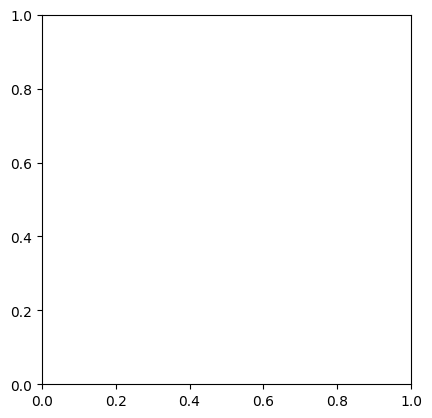

In [ ]:
for images, captions in train_loader:
    images = images.to(device)
    captions = captions.to(device)
    print(captions)
    for idxs in captions.tolist():
        sent = [vocabulary.itos[idx] for idx in idxs]
        print(sent)
        break
    plt.imshow(images[0].cpu())
    break
    predictions, alphas = model(images, captions)
    indexes = predictions.argmax(dim=-1)
    for idx in indexes.tolist():
        sent = [vocabulary.itos[idx] for idx in idx]
        print(sent)
    break

### What happens in validation

In [ ]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                         std=[0.26862954, 0.26130258, 0.27577711])
])
device = "cpu"
if torch.cuda.is_available():
    device = "cpu"
elif torch.backends.mps.is_available():
    device="mps"

print(f"Currently using the {device} device")
train_loader, dataset = get_loader(data_dict=train_data, transform=transform, vocabulary=vocabulary, image_folder="data/images/")
captioner = Caption(512, 512, 512, 512, len(vocabulary))
capitoner = model
captioner.to(device)
captioner.train()
for idx, (images, captions) in enumerate(train_loader):
    images= images.to(device)
    captions = captions.to(device)
    predictions, alpha = captioner(images, captions)
    words_idx = predictions.argmax(dim=-1)
    print(f"Shape of the cations batch: {captions.shape}")
    print(f"Shape of the prediction batch:{predictions.shape}")
    print(f"shape of word idx: {words_idx.shape}")
    print(f"shape of the alpha batch: {alpha.shape}")
    print(f"done with idx: {idx}")
    break


Currently using the mps device


/Users/ngkuissi/miniforge3/envs/ImageCap/lib/python3.8/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


Shape of the cations batch: torch.Size([32, 20])
Shape of the prediction batch:torch.Size([32, 20, 8508])
shape of word idx: torch.Size([32, 20])
shape of the alpha batch: torch.Size([32, 20, 196])
done with idx: 0


In [ ]:
image_path = 'data/images/10815824_2997e03d76.jpg'

# Load the image
image = Image.open(image_path)

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                         std=[0.26862954, 0.26130258, 0.27577711])
])

# Apply the transformation
image_tensor = transform(image)

# Add a batch dimension if needed
image_tensor = image_tensor.unsqueeze(0)
image_tensor = image_tensor.to(device)
model.caption_img(image_tensor, vocab=vocabulary)

RuntimeError: Placeholder storage has not been allocated on MPS device!

In [ ]:
import torch
import torch.nn as nn

class BahdanauAttention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super(BahdanauAttention, self).__init__()
        self.W_enc = nn.Linear(encoder_dim, attention_dim, bias=False)  # Transform encoder hidden states
        self.W_dec = nn.Linear(decoder_dim, attention_dim, bias=False)  # Transform decoder hidden state
        self.v = nn.Linear(attention_dim, 1, bias=False)  # Score function
        self.softmax = nn.Softmax(dim=1)  # Normalize attention scores

    def forward(self, encoder_outputs, decoder_hidden):
        """
        encoder_outputs: (batch_size, seq_len, encoder_dim)
        decoder_hidden: (batch_size, decoder_dim) - the last hidden state of the decoder
        
        Returns:
        - context vector: (batch_size, encoder_dim)
        - attention weights: (batch_size, seq_len)
        """
        # Expand decoder hidden state: (batch_size, 1, attention_dim)
        decoder_hidden_exp = self.W_dec(decoder_hidden).unsqueeze(1)
        
        # Compute attention scores: (batch_size, seq_len, attention_dim)
        scores = self.v(torch.tanh(self.W_enc(encoder_outputs) + decoder_hidden_exp))
        
        # Compute attention weights: (batch_size, seq_len, 1) → (batch_size, seq_len)
        attention_weights = self.softmax(scores.squeeze(2))
        
        # Compute context vector: (batch_size, encoder_dim)
        context_vector = torch.bmm(attention_weights.unsqueeze(1), encoder_outputs).squeeze(1)
        
        return context_vector, attention_weights


In [ ]:
import torch

# Define input dimensions
batch_size = 64    # Number of sequences in a batch
seq_len = 50       # Sequence length (number of time steps)
encoder_dim = 512  # Encoder hidden dimension
decoder_dim = 1024 # Decoder hidden dimension
attention_dim = 256 # Attention layer size

# Initialize the BahdanauAttention model
attention = BahdanauAttention(encoder_dim, decoder_dim, attention_dim)

# Simulate large encoder outputs (batch_size, seq_len, encoder_dim)
encoder_outputs = torch.rand(batch_size, seq_len, encoder_dim)

# Simulate decoder hidden state (batch_size, decoder_dim)
decoder_hidden = torch.rand(batch_size, decoder_dim)

# Pass through the attention layer
context_vector, attn_weights = attention(encoder_outputs, decoder_hidden)

# Print tensor shapes
print("Context Vector Shape:", context_vector.shape)  # Expected: (64, 512)
print("Attention Weights Shape:", attn_weights.shape) # Expected: (64, 50)
print(attn_weights.max(dim=-1))


Context Vector Shape: torch.Size([64, 512])
Attention Weights Shape: torch.Size([64, 50])
torch.return_types.max(
values=tensor([0.0229, 0.0232, 0.0228, 0.0225, 0.0241, 0.0239, 0.0237, 0.0234, 0.0231,
        0.0251, 0.0229, 0.0230, 0.0242, 0.0221, 0.0232, 0.0249, 0.0242, 0.0230,
        0.0232, 0.0240, 0.0239, 0.0271, 0.0237, 0.0239, 0.0231, 0.0236, 0.0233,
        0.0231, 0.0238, 0.0234, 0.0226, 0.0239, 0.0241, 0.0260, 0.0243, 0.0235,
        0.0236, 0.0240, 0.0226, 0.0236, 0.0229, 0.0260, 0.0244, 0.0245, 0.0235,
        0.0253, 0.0240, 0.0231, 0.0242, 0.0233, 0.0232, 0.0230, 0.0227, 0.0243,
        0.0236, 0.0242, 0.0231, 0.0232, 0.0241, 0.0250, 0.0248, 0.0235, 0.0238,
        0.0248], grad_fn=<MaxBackward0>),
indices=tensor([18, 14, 28,  7,  9, 46, 14, 41, 11,  8, 33, 37, 33, 12, 14, 17, 33, 12,
         9, 27, 42, 22,  4, 20, 17,  1, 45, 47, 13, 22, 33,  9,  5, 41,  1, 47,
        32, 34,  7, 35, 31,  6, 44, 17,  4,  2, 36, 31, 18,  2, 44, 10,  4, 27,
        33, 43, 18, 23, 33, 2